## 1 Introduction and Water Gauge Data


We have previously studied the Cologne water gauge during the time around January 2018 flooding of Cologne. The flood peaked at 8th of January according to *Kölner Pegel*, the local water gauge at the city center; with a recorded value of **8.71 m**, where the typical average runs around 2-3 meters. [According to StEB](https://steb-koeln.de/hochwasser-und-ueberflutungsschutz/hochwasser/hochwassermanagement/hochwassermanagement.jsp) (Cologne wastewater treatment company), the waterfront of Cologne old town is expected to be flooded starting from water gauge of **8.10 m**. The picture below is taken on 8th of January, showing the part of the riverbank along the oldtown of Cologne. It also shows the Pegel itself partially flooded at the center left, in front of the trees. Detailed information about the properties and history of the Kölner Pegel can be found [here](https://undine.bafg.de/rhein/pegel/rhein_pegel_koeln.html).

<figure style="text-align:center;">
  <img src="images/jan18.jpg" 
       alt="Rhine flood Cologne 2018" 
       width="450" 
       style="border:2px solid black;">
  <figcaption style="font-style:italic; color:gray; margin-top:5px;">
    Figure 1. Rhine flood in Cologne's oldtown, 8 January 2018 © Superbass / CC-BY-SA-4.0 (via Wikimedia Commons) (modified)
  </figcaption>
</figure>

#### Purpose and workflow
Our previous study is qualitatively in agreement with literature in the sense that we saw flood peak is underestimated by the forecasts. We now want to use a larger timeline including not only a single flood, but general river regime and build a Machine-learning (ML) regression model to predict the Cologne water gauge height at different lead-times such as 1, 3 and 7 days.

We will split the work in various notebooks. In this first one (ML1) we will look at our target, Koelner Pegel and then add some other Pegels upstream to it, either on Rhine or on one of its tributaries as our first input variables for the later training. In the next notebook (ML2) we will study and define the catchment area of Rhine in Cologne and the subbasins within this area. This geographic filter will be used work with inputs only in an area that could impact our target. Subbasins will add some spatial differentiation as using inputs from whole cathchment would average out regional differences that could impact the target at different times and rates. Subbasins are causally better connected to main tributaries for example, such as Moselle or Main rivers. 

After having defined the basins, we will add (ML3.X) further variables such as temperature, radiation, snow, precipitation and humidity and create them for each introduced subbasin. This will complete our work on producing input variables. Then, we move on (ML4.X) to clean the dataset, handling NaNs or weird extreme values, scale all the inputs and check once again to make sure all looks good.

Next, we are ready to train and optimize our ML models, followed by performance checks and comparisons.


#### Disclaimer

Please note that this is my first ever study of a hydrology topic and such type of datasets and I claim no expertise. I learned lot of things on these topics while working on this topic. There might be technical mistakes in calculations or in the interpretation of outcomes. I appreciate any feedback, comments or corrections greatly!

#### Datasets
- Water gauge datasets used in this notebook are available [here](https://www.wasserstaende.de/gast/stammdaten?pegelnr=2730010).

<figure style="text-align:center;">
  <img src="images/rheincatchment.jpg" 
       alt="Rhine flood Cologne 2018" 
       width="400" 
       style="border:2px solid black;">
  <figcaption style="font-style:italic; color:gray; margin-top:5px;">
    Figure 2. Basin of river Rhein © WWasser / CC-BY-SA-4.0 (via Wikimedia Commons)
  </figcaption>
</figure>

### Useful links

- https://vorhersage.bafg.de/14-Tage-Vorhersage/Koeln_14Tage.pdf
- https://www.geoportal.de/Info/45891cdc-5354-41a2-8da1-52e7de0fd3a5
- https://data.europa.eu/data/datasets/45891cdc-5354-41a2-8da1-52e7de0fd3a5~~1?locale=en
- https://www.govdata.de/suche/daten/14-tage-wasserstandsvorhersagen-fur-ausgewahlte-rheinpegel
- https://www.elwis.de/DE/dynamisch/Wasserstaende/Pegelvorhersage:K%C3%96LN
- https://hess.copernicus.org/articles/15/3355/2011/
- https://freidok.uni-freiburg.de/data/233639
- https://github.com/ERottler/rhine-flood-genesis
- https://onlinelibrary.wiley.com/doi/epdf/10.1002/hyp.5908
- https://www.hochwasserportal.nrw/webpublic/index.html#/overview/Wasserstand?period=P7D

### **Kölner Pegel obervational dataset**

Here, we first study the water height datasets recorded by the Pegel. This is the value we want to predict

In [1]:
# Read-in the water level dataset and check the content
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
INF_str = "/Users/oncel/Documents/Projects/KoelnPegelML/data/"

W_path = "/Users/oncel/Documents/Projects/KoelnPegelML/data/pegelonline-kln-W-20000101-20250903.csv"
Q_path = "/Users/oncel/Documents/Projects/KoelnPegelML/data/pegelonline-kln-Q-20000101-20250903.csv"

dfW = pd.read_csv(W_path, sep=";", parse_dates=["timestamp"])
dfQ = pd.read_csv(Q_path, sep=";", parse_dates=["timestamp"])

print(dfW.head())

            timestamp  value
0 2000-01-01 01:00:00    701
1 2000-01-01 01:15:00    700
2 2000-01-01 01:30:00    699
3 2000-01-01 01:45:00    698
4 2000-01-01 02:00:00    697


Let's check if the dataset contains problematic values that should be handled or excluded

In [2]:
print(dfW.max(),dfW.min())

timestamp    2025-09-03 12:00:00
value                        971
dtype: object timestamp    2000-01-01 01:00:00
value                         67
dtype: object


In [3]:
dfW.isna().any()

timestamp    False
value        False
dtype: bool

In [4]:
dfW["date"] = pd.to_datetime(dfW["timestamp"])
dfW = dfW.set_index("timestamp")

dfQ["date"] = pd.to_datetime(dfQ["timestamp"])
dfQ = dfQ.set_index("timestamp")

In [5]:
dfW_D = dfW.resample("D").mean()
dfW_M = dfW.resample("1M").mean()
dfW_Y = dfW.resample("12M").mean()

dfQ_M = dfQ.resample("1M").mean()
dfQ_Y = dfQ.resample("12M").mean()

/var/folders/m_/rxrf1frn6xnfy96jfshlm3lr0000gn/T/ipykernel_34270/775685129.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dfW_M = dfW.resample("1M").mean()
/var/folders/m_/rxrf1frn6xnfy96jfshlm3lr0000gn/T/ipykernel_34270/775685129.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dfW_Y = dfW.resample("12M").mean()
/var/folders/m_/rxrf1frn6xnfy96jfshlm3lr0000gn/T/ipykernel_34270/775685129.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dfQ_M = dfQ.resample("1M").mean()
/var/folders/m_/rxrf1frn6xnfy96jfshlm3lr0000gn/T/ipykernel_34270/775685129.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dfQ_Y = dfQ.resample("12M").mean()


In [6]:
# Quarter century mean height
dfW["value"].mean()

np.float64(310.90345277278215)

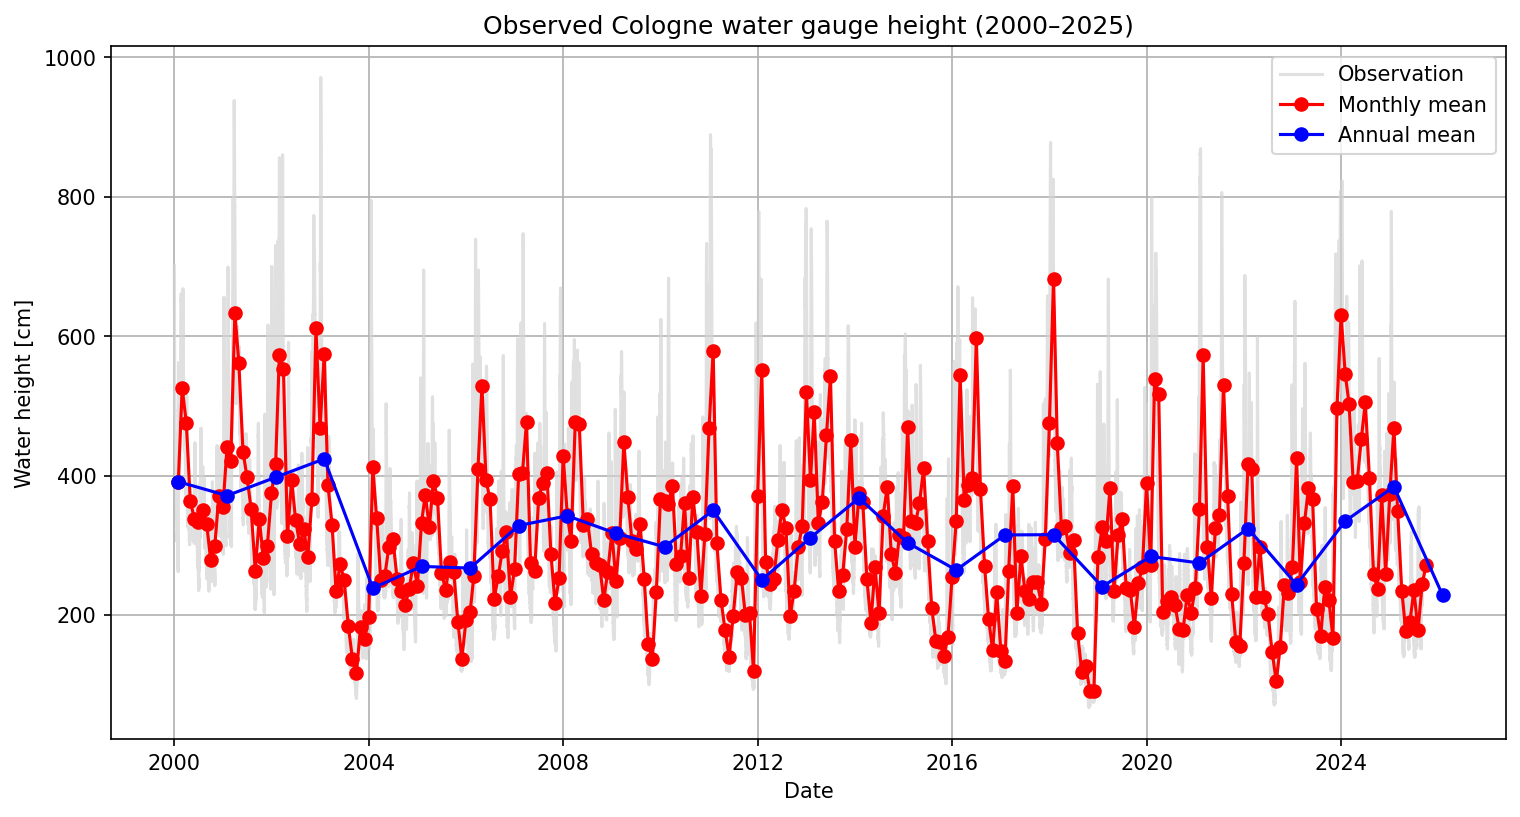

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=150)

# Daily (raw)
plt.plot(dfW.index, dfW["value"], color="lightgray", alpha=0.7, label="Observation")

# Monthly mean (red line with dots)
plt.plot(dfW_M.index, dfW_M["value"], "ro-", label="Monthly mean")

plt.plot(dfW_Y.index, dfW_Y["value"], "bo-", label="Annual mean")

plt.xlabel("Date")
plt.ylabel("Water height [cm]")
plt.title("Observed Cologne water gauge height (2000–2025)")
plt.legend()
plt.grid(True)
plt.show()

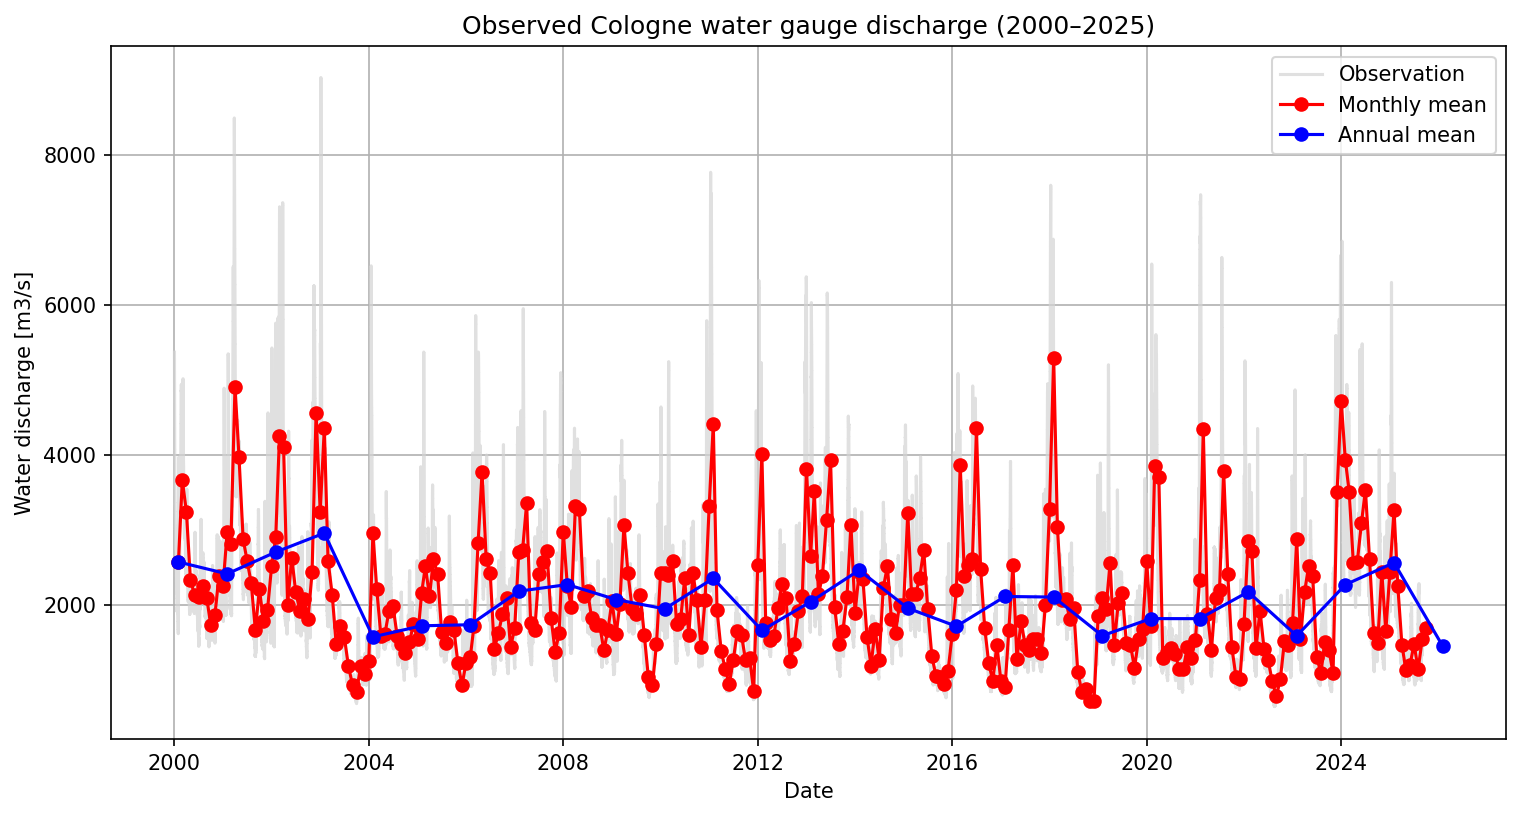

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=150)

# Daily (raw)
plt.plot(dfQ.index, dfQ["value"], color="lightgray", alpha=0.7, label="Observation")

# Monthly mean (red line with dots)
plt.plot(dfQ_M.index, dfQ_M["value"], "ro-", label="Monthly mean")

plt.plot(dfQ_Y.index, dfQ_Y["value"], "bo-", label="Annual mean")

plt.xlabel("Date")
plt.ylabel("Water discharge [m3/s]")
plt.title("Observed Cologne water gauge discharge (2000–2025)")
plt.legend()
plt.grid(True)
plt.show()

Let's have quick look at the instances the old town river bank was flooded (h > 810 cm) in this quarter century:

In [9]:
# Filter values above 810 cm
high_water = dfW[dfW["value"] > 810]

# Extract only the date (no time), drop duplicates
unique_dates = high_water.index.normalize().unique()

print(unique_dates)

DatetimeIndex(['2001-03-23', '2001-03-24', '2001-03-25', '2001-03-26',
               '2001-03-27', '2001-03-28', '2001-03-29', '2002-02-27',
               '2002-02-28', '2002-03-01', '2002-03-02', '2002-03-23',
               '2002-03-24', '2002-03-25', '2003-01-03', '2003-01-04',
               '2003-01-05', '2003-01-06', '2003-01-07', '2003-01-08',
               '2011-01-09', '2011-01-10', '2011-01-11', '2011-01-12',
               '2011-01-14', '2011-01-15', '2011-01-16', '2011-01-17',
               '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09',
               '2018-01-10', '2018-01-26', '2018-01-27', '2021-02-02',
               '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-06',
               '2021-02-07', '2021-02-08', '2021-02-09', '2024-01-05',
               '2024-01-06'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


We see the there were floodings on 2001, 2002, 2003, 2011, 2018, 2021 and 2024. Floods took place always on one of the first three months of the year. We previously studied 2018 January flood in another Notebook.

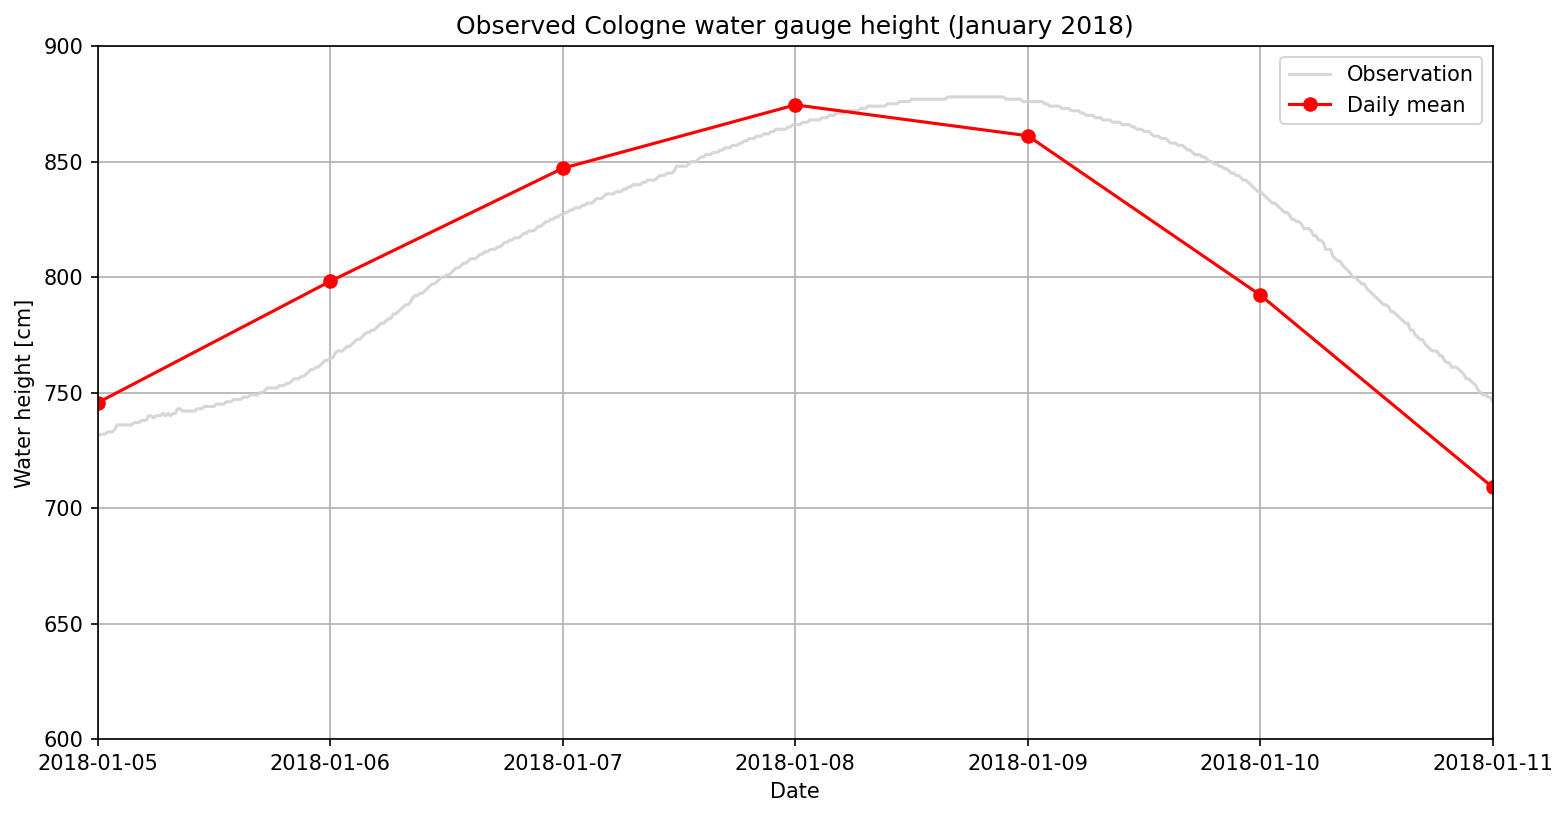

In [10]:

plt.figure(figsize=(12,6), dpi=150)

# Daily (raw)
plt.plot(dfW.index, dfW["value"], color="lightgray", alpha=0.9, label="Observation")

# Monthly mean (red line with dots)
plt.plot(dfW_D.index, dfW_D["value"], "ro-", label="Daily mean")

plt.xlim(pd.Timestamp("2018-01-05"), pd.Timestamp("2018-01-11"))
plt.ylim(600, 900)
plt.xlabel("Date")
plt.ylabel("Water height [cm]")
plt.title("Observed Cologne water gauge height (January 2018)")
plt.legend()
plt.grid(True)
plt.show()

Let's note that, averaging over a day shifts the maximum of this flood slightly earlier. The peak happened towards the evening of 8th, but since we lose sub-daily resolution we don't see it anymore.

## We now add some columns to the dataset we will eventually want to use in the training:

In [11]:
# Daily mean and difference
Kln_dfW_daily = dfW.resample("D").mean()   # daily mean
Kln_dfW_daily["Kln_diff"] = Kln_dfW_daily["value"].diff()
Kln_dfW_daily["Kln_q"] = dfQ["value"].resample("D").mean()   # daily mean
Kln_dfW_daily.rename(columns={"value": "Kln_h"}, inplace=True)
print(Kln_dfW_daily.max(),Kln_dfW_daily.min())
print(Kln_dfW_daily.isna().any())
Kln_dfW_daily

Kln_h                959.479167
date        2025-09-03 06:00:00
Kln_diff             261.583333
Kln_q               8844.041667
dtype: object Kln_h                  68.59375
date        2000-01-01 12:22:30
Kln_diff            -119.010417
Kln_q                638.270833
dtype: object
Kln_h       False
date        False
Kln_diff     True
Kln_q       False
dtype: bool


,Kln_h,date,Kln_diff,Kln_q
timestamp,,,,
2000-01-01,658.239130,2000-01-01 12:22:30,NaN,4917.119565
2000-01-02,599.583333,2000-01-02 11:52:30,-58.655797,4326.812500
2000-01-03,554.885417,2000-01-03 11:52:30,-44.697917,3905.354167
2000-01-04,517.239583,2000-01-04 11:52:30,-37.645833,3565.989583
2000-01-05,495.114583,2000-01-05 11:52:30,-22.125000,3373.135417
...,...,...,...,...
2025-08-30,224.729167,2025-08-30 11:52:30,10.489583,1401.666667
2025-08-31,251.989583,2025-08-31 11:52:30,27.260417,1571.427083
2025-09-01,275.406250,2025-09-01 11:52:30,23.416667,1723.906250


In [12]:
## Rating Equation for 2000-2025 Koelner Pegel

# Pearson correlation coefficient
corr = dfW["value"].corr(dfQ["value"], method="pearson")
print("Correlation coefficient:", corr)

Correlation coefficient: 0.9907913904724509


This relationship between discharge and water level is expected and scientifically described with a power-law-following Rating Curve:
$$ Q = a \, (h - h_{0})^{b} $$
where

$Q$: discharge $\;\; [\tfrac{m^{3}}{s}]$  
$h$: water level (stage) [m]  
$h_{0}$: threshold stage (zero-flow level) [m]  
$a,b$: empirical coefficients (dimensionless) 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Observed pegel data
height_cm = np.array(dfW["value"]) # W
discharge = np.array(dfQ["value"]) # Q

print(len(height_cm), len(discharge))

900233 900233


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Convert cm → m
height_m = height_cm / 100.0

# Define rating curve function
def rating_curve(h, a, h0, b):
    return a * np.maximum(h - h0, 0)**b

# Initial guesses and bounds
params, cov = curve_fit(
    rating_curve,
    dfW["value"]/100,
    dfQ["value"],
    p0=[1000, 3.5, 2],              
    bounds=([0, 0, 0.5], [1e5, 6, 5])  
)

a, h0, b = params
print(f"Fitted rating curve: Q = {a:.2f} * (h - {h0:.2f})^{b:.2f}")
print(f"Thus, a = {a:.2f}, b= {b:.2f} and h_0 = {h0:.2f}")

Fitted rating curve: Q = 522.83 * (h - 0.00)^1.19
Thus, a = 522.83, b= 1.19 and h_0 = 0.00


In [15]:
# Function to calculate water height from discharge
def h_from_Q(Q):
    """
    Compute water stage (h) from discharge (Q) 
    using rating curve: Q = 344.32 * (h)^1.42
    """
    a = 2176.39
    b = 2.97
    h0 = 2.00  # threshold

    return ((Q / a) ** (1 / b)) + h0

## Other Relevant Pegels

Here, the idea is to use some gauges located at critical points, ideally representing the contribution of main tributaries to Rhine, to introduce more predictive power. Gauges with data available since 2000 are chosen when multiple gauges were present on a water way.

For the case of Middle Rhein, given average 5km/h average speed (that changes with flood regime and varies regionally though!) of Rhein, and 24h prediction target, we take some Pegels 120-125 rhine kilometers upstream such as Kaub, Sankt Goara and Bingen.

Tributary/region and representative Gauge chosen:
- Aare -> (Add later?)
- Ahr -> Bad Bodendorf
- Lahn -> kalkofenneu
- Main -> frankfurtosthafen
- Middle Rhein upstream from Cologne: Kaub, Sankt Goar, Bingen
- Neckar -> Heidelberg Up
- Moselle -> Rudew
- Sieg -> Betzendorf
- Rhine Alpine Source -> Rheinweiler

Creating DF for each Pegel:

In [16]:
Fra_W_path = INF_str+"pegelonline-frankfurtosthafen-W-20000101-20250903.csv"
Fra_dfW = pd.read_csv(Fra_W_path, sep=";", parse_dates=["timestamp"])
Fra_dfW["date"] = pd.to_datetime(Fra_dfW["timestamp"])
Fra_dfW = Fra_dfW.set_index("timestamp")
Fra_dfW_daily = Fra_dfW.resample("D").mean()   # daily mean
Fra_dfW_daily["Fra_diff"] = Fra_dfW_daily["value"].diff()
Fra_dfW_daily.rename(columns={"value": "Fra_h"}, inplace=True)
print(Fra_dfW_daily.max(),Fra_dfW_daily.min())
print(Fra_dfW_daily.isna().any())
Fra_dfW_daily
Fra_dfW_daily

Fra_h                508.927083
date        2025-09-03 08:07:30
Fra_diff              92.583333
dtype: object Fra_h                 148.90625
date        2000-01-01 12:22:30
Fra_diff            -117.177083
dtype: object
Fra_h       False
date        False
Fra_diff     True
dtype: bool


,Fra_h,date,Fra_diff
timestamp,,,
2000-01-01,195.782609,2000-01-01 12:22:30,NaN
2000-01-02,185.875000,2000-01-02 11:52:30,-9.907609
2000-01-03,185.854167,2000-01-03 11:52:30,-0.020833
2000-01-04,181.718750,2000-01-04 11:52:30,-4.135417
2000-01-05,179.125000,2000-01-05 11:52:30,-2.593750
...,...,...,...
2025-08-30,158.489583,2025-08-30 11:52:30,1.218750
2025-08-31,157.322917,2025-08-31 11:52:30,-1.166667
2025-09-01,155.510417,2025-09-01 11:52:30,-1.812500


In [17]:
Ruw_W_path = INF_str+"pegelonline-ruwer-W-20000101-20250903.csv"
Ruw_dfW = pd.read_csv(Ruw_W_path, sep=";", parse_dates=["timestamp"])

Ruw_dfW["date"] = pd.to_datetime(Ruw_dfW["timestamp"])
Ruw_dfW = Ruw_dfW.set_index("timestamp")
Ruw_dfW_daily = Ruw_dfW.resample("D").mean()   # daily mean
Ruw_dfW_daily["Ruw_diff"] = Ruw_dfW_daily["value"].diff()
Ruw_dfW_daily.rename(columns={"value": "Ruw_h"}, inplace=True)
print(Ruw_dfW_daily.max(),Ruw_dfW_daily.min())
print(Ruw_dfW_daily.isna().any())
Ruw_dfW_daily

Ruw_h                745.385417
date        2025-09-03 11:52:30
Ruw_diff             337.427083
dtype: object Ruw_h                  195.5625
date        2000-01-01 12:22:30
Ruw_diff            -155.552083
dtype: object
Ruw_h       False
date        False
Ruw_diff     True
dtype: bool


,Ruw_h,date,Ruw_diff
timestamp,,,
2000-01-01,415.782609,2000-01-01 12:22:30,NaN
2000-01-02,388.468750,2000-01-02 11:52:30,-27.313859
2000-01-03,361.312500,2000-01-03 11:52:30,-27.156250
2000-01-04,341.687500,2000-01-04 11:52:30,-19.625000
2000-01-05,340.864583,2000-01-05 11:52:30,-0.822917
...,...,...,...
2025-08-30,225.364583,2025-08-30 11:52:30,2.614583
2025-08-31,223.437500,2025-08-31 11:52:30,-1.927083
2025-09-01,228.864583,2025-09-01 11:52:30,5.427083


In [18]:
Hdb_W_path = INF_str+"pegelonline-heidelbergup-W-20000101-20250903.csv"
Hdb_dfW = pd.read_csv(Hdb_W_path, sep=";", parse_dates=["timestamp"])

Hdb_dfW["date"] = pd.to_datetime(Hdb_dfW["timestamp"])
Hdb_dfW = Hdb_dfW.set_index("timestamp")
Hdb_dfW_daily = Hdb_dfW.resample("D").mean()   # daily mean
Hdb_dfW_daily["Hdb_diff"] = Hdb_dfW_daily["value"].diff()
Hdb_dfW_daily.rename(columns={"value": "Hdb_h"}, inplace=True)
print(Hdb_dfW_daily.max(),Hdb_dfW_daily.min())
print(Hdb_dfW_daily.isna().any())
Hdb_dfW_daily

Hdb_h                 523.59375
date        2025-09-03 08:30:00
Hdb_diff             203.927083
dtype: object Hdb_h                199.416667
date        2000-01-01 12:22:30
Hdb_diff            -127.166667
dtype: object
Hdb_h       False
date        False
Hdb_diff     True
dtype: bool


,Hdb_h,date,Hdb_diff
timestamp,,,
2000-01-01,228.119565,2000-01-01 12:22:30,NaN
2000-01-02,227.927083,2000-01-02 11:52:30,-0.192482
2000-01-03,231.802083,2000-01-03 11:52:30,3.875000
2000-01-04,226.875000,2000-01-04 11:52:30,-4.927083
2000-01-05,225.489583,2000-01-05 11:52:30,-1.385417
...,...,...,...
2025-08-30,210.375000,2025-08-30 11:52:30,-0.145833
2025-08-31,210.437500,2025-08-31 11:52:30,0.062500
2025-09-01,210.708333,2025-09-01 11:52:30,0.270833


In [19]:
Klk_W_path = INF_str+"pegelonline-kalkofenneu-W-20000101-20250903.csv"
Klk_dfW = pd.read_csv(Klk_W_path, sep=";", parse_dates=["timestamp"])

Klk_dfW["date"] = pd.to_datetime(Klk_dfW["timestamp"])
Klk_dfW = Klk_dfW.set_index("timestamp")
Klk_dfW_daily = Klk_dfW.resample("D").mean()   # daily mean
Klk_dfW_daily["Klk_diff"] = Klk_dfW_daily["value"].diff()
Klk_dfW_daily.rename(columns={"value": "Klk_h"}, inplace=True)
print(Klk_dfW_daily.max(),Klk_dfW_daily.min())
print(Klk_dfW_daily.isna().any())
Klk_dfW_daily

Klk_h                752.104167
date        2025-09-03 08:07:30
Klk_diff             214.333333
dtype: object Klk_h                170.520833
date        2000-01-01 12:22:30
Klk_diff            -108.916667
dtype: object
Klk_h       False
date        False
Klk_diff     True
dtype: bool


,Klk_h,date,Klk_diff
timestamp,,,
2000-01-01,302.836957,2000-01-01 12:22:30,NaN
2000-01-02,289.833333,2000-01-02 11:52:30,-13.003623
2000-01-03,281.895833,2000-01-03 11:52:30,-7.937500
2000-01-04,276.354167,2000-01-04 11:52:30,-5.541667
2000-01-05,308.843750,2000-01-05 11:52:30,32.489583
...,...,...,...
2025-08-30,180.635417,2025-08-30 11:52:30,-2.375000
2025-08-31,176.916667,2025-08-31 11:52:30,-3.718750
2025-09-01,175.802083,2025-09-01 11:52:30,-1.114583


In [20]:
Rhw_W_path = INF_str+"pegelonline-rheinweiler-W-20000101-20250903.csv"
Rhw_dfW = pd.read_csv(Rhw_W_path, sep=";", parse_dates=["timestamp"])

Rhw_dfW["date"] = pd.to_datetime(Rhw_dfW["timestamp"])
Rhw_dfW = Rhw_dfW.set_index("timestamp")
Rhw_dfW_daily = Rhw_dfW.resample("D").mean()   # daily mean
Rhw_dfW_daily["Rhw_diff"] = Rhw_dfW_daily["value"].diff()
Rhw_dfW_daily.rename(columns={"value": "Rhw_h"}, inplace=True)
print(Rhw_dfW_daily.max(),Rhw_dfW_daily.min())
print(Rhw_dfW_daily.isna().any())
Rhw_dfW_daily

Rhw_h                779.864583
date        2025-09-03 11:52:30
Rhw_diff             501.291667
dtype: object Rhw_h                     155.0
date        2000-01-01 12:22:30
Rhw_diff              -196.0625
dtype: object
Rhw_h       False
date        False
Rhw_diff     True
dtype: bool


,Rhw_h,date,Rhw_diff
timestamp,,,
2000-01-01,163.695652,2000-01-01 12:22:30,NaN
2000-01-02,162.687500,2000-01-02 11:52:30,-1.008152
2000-01-03,164.416667,2000-01-03 11:52:30,1.729167
2000-01-04,165.333333,2000-01-04 11:52:30,0.916667
2000-01-05,165.770833,2000-01-05 11:52:30,0.437500
...,...,...,...
2025-08-30,222.156250,2025-08-30 11:52:30,6.427083
2025-08-31,221.760417,2025-08-31 11:52:30,-0.395833
2025-09-01,220.604167,2025-09-01 11:52:30,-1.156250


In [21]:
Stg_W_path = INF_str+"pegelonline-sanktgoar-W-20000101-20250903.csv"
Stg_dfW = pd.read_csv(Stg_W_path, sep=";", parse_dates=["timestamp"])

Stg_dfW["date"] = pd.to_datetime(Stg_dfW["timestamp"])
Stg_dfW = Stg_dfW.set_index("timestamp")
Stg_dfW_daily = Stg_dfW.resample("D").mean()   # daily mean
Stg_dfW_daily["Stg_diff"] = Stg_dfW_daily["value"].diff()
Stg_dfW_daily.rename(columns={"value": "Stg_h"}, inplace=True)
print(Stg_dfW_daily.max(),Stg_dfW_daily.min())
print(Stg_dfW_daily.isna().any())
Stg_dfW_daily

Stg_h                 817.01087
date        2025-09-03 11:52:30
Stg_diff             174.177083
dtype: object Stg_h                107.854167
date        2000-01-01 12:22:30
Stg_diff             -84.520833
dtype: object
Stg_h       False
date        False
Stg_diff     True
dtype: bool


,Stg_h,date,Stg_diff
timestamp,,,
2000-01-01,550.978261,2000-01-01 12:22:30,NaN
2000-01-02,513.260417,2000-01-02 11:52:30,-37.717844
2000-01-03,480.614583,2000-01-03 11:52:30,-32.645833
2000-01-04,458.552083,2000-01-04 11:52:30,-22.062500
2000-01-05,440.875000,2000-01-05 11:52:30,-17.677083
...,...,...,...
2025-08-30,298.364583,2025-08-30 11:52:30,28.197917
2025-08-31,327.135417,2025-08-31 11:52:30,28.770833
2025-09-01,323.697917,2025-09-01 11:52:30,-3.437500


In [22]:
Bng_W_path = INF_str+"pegelonline-bingen-W-20000101-20250903.csv"
Bng_dfW = pd.read_csv(Bng_W_path, sep=";", parse_dates=["timestamp"])

Bng_dfW["date"] = pd.to_datetime(Bng_dfW["timestamp"])
Bng_dfW = Bng_dfW.set_index("timestamp")
Bng_dfW_daily = Bng_dfW.resample("D").mean()   # daily mean
Bng_dfW_daily["Bng_diff"] = Bng_dfW_daily["value"].diff()
Bng_dfW_daily.rename(columns={"value": "Bng_h"}, inplace=True)
print(Bng_dfW_daily.max(),Bng_dfW_daily.min())
print(Bng_dfW_daily.isna().any())
Bng_dfW_daily

Bng_h                    555.25
date        2025-09-03 11:52:30
Bng_diff               124.3125
dtype: object Bng_h                 45.833333
date        2000-01-01 12:22:30
Bng_diff               -61.9375
dtype: object
Bng_h       False
date        False
Bng_diff     True
dtype: bool


,Bng_h,date,Bng_diff
timestamp,,,
2000-01-01,359.304348,2000-01-01 12:22:30,NaN
2000-01-02,333.125000,2000-01-02 11:52:30,-26.179348
2000-01-03,310.666667,2000-01-03 11:52:30,-22.458333
2000-01-04,294.916667,2000-01-04 11:52:30,-15.750000
2000-01-05,282.041667,2000-01-05 11:52:30,-12.875000
...,...,...,...
2025-08-30,187.760417,2025-08-30 11:52:30,20.125000
2025-08-31,204.364583,2025-08-31 11:52:30,16.604167
2025-09-01,198.010417,2025-09-01 11:52:30,-6.354167


In [23]:
Kau_W_path = INF_str+"pegelonline-kaub-W-20000101-20250903.csv"
Kau_dfW = pd.read_csv(Kau_W_path, sep=";", parse_dates=["timestamp"])

Kau_dfW["date"] = pd.to_datetime(Kau_dfW["timestamp"])
Kau_dfW = Kau_dfW.set_index("timestamp")
Kau_dfW_daily = Kau_dfW.resample("D").mean()   # daily mean
Kau_dfW_daily["Kau_diff"] = Kau_dfW_daily["value"].diff()
Kau_dfW_daily.rename(columns={"value": "Kau_h"}, inplace=True)
print(Kau_dfW_daily.max(),Kau_dfW_daily.min())
print(Kau_dfW_daily.isna().any())
Kau_dfW_daily

Kau_h                718.145833
date        2025-09-03 11:52:30
Kau_diff             175.489583
dtype: object Kau_h                  25.28125
date        2000-01-01 12:22:30
Kau_diff             -88.354167
dtype: object
Kau_h       False
date        False
Kau_diff     True
dtype: bool


,Kau_h,date,Kau_diff
timestamp,,,
2000-01-01,438.989130,2000-01-01 12:22:30,NaN
2000-01-02,401.260417,2000-01-02 11:52:30,-37.728714
2000-01-03,367.989583,2000-01-03 11:52:30,-33.270833
2000-01-04,346.093750,2000-01-04 11:52:30,-21.895833
2000-01-05,327.968750,2000-01-05 11:52:30,-18.125000
...,...,...,...
2025-08-30,196.437500,2025-08-30 11:52:30,26.104167
2025-08-31,221.260417,2025-08-31 11:52:30,24.822917
2025-09-01,216.104167,2025-09-01 11:52:30,-5.156250


In [24]:
Sie_W_path = INF_str+"sieg_betzendorf.csv"

Sie_dfW = pd.read_csv(Sie_W_path, sep=";", parse_dates=["Timestamp"], dayfirst=True)

Sie_dfW["date"] = pd.to_datetime(Sie_dfW["Timestamp"])
Sie_dfW = Sie_dfW.set_index("Timestamp")
Sie_dfW_daily = Sie_dfW.resample("D").mean()   # daily mean
Sie_dfW_daily["Sie_diff"] = Sie_dfW_daily["value"].diff()
Sie_dfW_daily.rename(columns={"value": "Sie_h"}, inplace=True)
print(Sie_dfW_daily.max(),Sie_dfW_daily.min())
print(Sie_dfW_daily.isna().any())
Sie_dfW_daily

Sie_h                     343.0
date        2025-09-03 00:00:00
Sie_diff                  201.0
dtype: object Sie_h                      28.0
date        2000-01-01 00:00:00
Sie_diff                  -97.0
dtype: object
Sie_h       False
date        False
Sie_diff     True
dtype: bool


,Sie_h,date,Sie_diff
Timestamp,,,
2000-01-01,103.0,2000-01-01,NaN
2000-01-02,98.0,2000-01-02,-5.0
2000-01-03,94.0,2000-01-03,-4.0
2000-01-04,100.0,2000-01-04,6.0
2000-01-05,116.0,2000-01-05,16.0
...,...,...,...
2025-08-30,37.0,2025-08-30,-7.0
2025-08-31,35.0,2025-08-31,-2.0
2025-09-01,36.0,2025-09-01,1.0


In [25]:
Ahr_W_path = INF_str+"ahr_badbodendorf.csv"

Ahr_dfW = pd.read_csv(Ahr_W_path, sep=";", parse_dates=["Timestamp"], dayfirst=True)

Ahr_dfW["date"] = pd.to_datetime(Ahr_dfW["Timestamp"])
Ahr_dfW = Ahr_dfW.set_index("Timestamp")
Ahr_dfW_daily = Ahr_dfW.resample("D").mean()   # daily mean
Ahr_dfW_daily["Ahr_diff"] = Ahr_dfW_daily["value"].diff()
Ahr_dfW_daily.rename(columns={"value": "Ahr_h"}, inplace=True)
print(Ahr_dfW_daily.max(),Ahr_dfW_daily.min())
print(Ahr_dfW_daily.isna().any())
Ahr_dfW_daily

Ahr_h                     408.0
date        2025-09-03 00:00:00
Ahr_diff                  237.0
dtype: object Ahr_h                      22.0
date        2000-01-01 00:00:00
Ahr_diff                  -57.0
dtype: object
Ahr_h       True
date        True
Ahr_diff    True
dtype: bool


,Ahr_h,date,Ahr_diff
Timestamp,,,
2000-01-01,95.0,2000-01-01,NaN
2000-01-02,91.0,2000-01-02,-4.0
2000-01-03,88.0,2000-01-03,-3.0
2000-01-04,85.0,2000-01-04,-3.0
2000-01-05,87.0,2000-01-05,2.0
...,...,...,...
2025-08-30,44.0,2025-08-30,0.0
2025-08-31,44.0,2025-08-31,0.0
2025-09-01,47.0,2025-09-01,3.0


## Create a combined df

We include all variables we produced for later usage in the ML training.

In [26]:
df_all = pd.concat([Kln_dfW_daily["Kln_h"],
                    Kln_dfW_daily["Kln_diff"], 
                    Fra_dfW_daily["Fra_h"], 
                    Fra_dfW_daily["Fra_diff"],
                    Ruw_dfW_daily["Ruw_h"], 
                    Ruw_dfW_daily["Ruw_diff"],
                    Klk_dfW_daily["Klk_h"], 
                    Klk_dfW_daily["Klk_diff"],
                    Rhw_dfW_daily["Rhw_h"], 
                    Rhw_dfW_daily["Rhw_diff"],
                    Kau_dfW_daily["Kau_h"], 
                    Kau_dfW_daily["Kau_diff"],
                    Bng_dfW_daily["Bng_h"], 
                    Bng_dfW_daily["Bng_diff"],
                    Sie_dfW_daily["Sie_h"], 
                    Sie_dfW_daily["Sie_diff"],
                    Stg_dfW_daily["Stg_h"], 
                    Stg_dfW_daily["Stg_diff"],
                    Ahr_dfW_daily["Ahr_h"], 
                    Ahr_dfW_daily["Ahr_diff"],
                    Hdb_dfW_daily["Hdb_h"], 
                    Hdb_dfW_daily["Hdb_diff"]],axis=1)
df_all

,Kln_h,Kln_diff,Fra_h,Fra_diff,Ruw_h,Ruw_diff,Klk_h,Klk_diff,Rhw_h,Rhw_diff,...,Bng_h,Bng_diff,Sie_h,Sie_diff,Stg_h,Stg_diff,Ahr_h,Ahr_diff,Hdb_h,Hdb_diff
2000-01-01,658.239130,NaN,195.782609,NaN,415.782609,NaN,302.836957,NaN,163.695652,NaN,...,359.304348,NaN,103.0,NaN,550.978261,NaN,95.0,NaN,228.119565,NaN
2000-01-02,599.583333,-58.655797,185.875000,-9.907609,388.468750,-27.313859,289.833333,-13.003623,162.687500,-1.008152,...,333.125000,-26.179348,98.0,-5.0,513.260417,-37.717844,91.0,-4.0,227.927083,-0.192482
2000-01-03,554.885417,-44.697917,185.854167,-0.020833,361.312500,-27.156250,281.895833,-7.937500,164.416667,1.729167,...,310.666667,-22.458333,94.0,-4.0,480.614583,-32.645833,88.0,-3.0,231.802083,3.875000
2000-01-04,517.239583,-37.645833,181.718750,-4.135417,341.687500,-19.625000,276.354167,-5.541667,165.333333,0.916667,...,294.916667,-15.750000,100.0,6.0,458.552083,-22.062500,85.0,-3.0,226.875000,-4.927083
2000-01-05,495.114583,-22.125000,179.125000,-2.593750,340.864583,-0.822917,308.843750,32.489583,165.770833,0.437500,...,282.041667,-12.875000,116.0,16.0,440.875000,-17.677083,87.0,2.0,225.489583,-1.385417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30,224.729167,10.489583,158.489583,1.218750,225.364583,2.614583,180.635417,-2.375000,222.156250,6.427083,...,187.760417,20.125000,37.0,-7.0,298.364583,28.197917,44.0,0.0,210.375000,-0.145833
2025-08-31,251.989583,27.260417,157.322917,-1.166667,223.437500,-1.927083,176.916667,-3.718750,221.760417,-0.395833,...,204.364583,16.604167,35.0,-2.0,327.135417,28.770833,44.0,0.0,210.437500,0.062500
2025-09-01,275.406250,23.416667,155.510417,-1.812500,228.864583,5.427083,175.802083,-1.114583,220.604167,-1.156250,...,198.010417,-6.354167,36.0,1.0,323.697917,-3.437500,47.0,3.0,210.708333,0.270833
2025-09-02,273.270833,-2.135417,156.729167,1.218750,225.583333,-3.281250,175.020833,-0.781250,216.364583,-4.239583,...,187.468750,-10.541667,36.0,0.0,306.375000,-17.322917,51.0,4.0,212.062500,1.354167


In [27]:
df_all.to_csv("data/train_pegels_preprocessed.csv", index=True)  # Save for later processing

## Compare variables

Looking into how/if variables are correlated and distributed.

In [28]:
df_all = df_all.dropna(how="any")   # drop rows where any column NaN

In [29]:
df_all

,Kln_h,Kln_diff,Fra_h,Fra_diff,Ruw_h,Ruw_diff,Klk_h,Klk_diff,Rhw_h,Rhw_diff,...,Bng_h,Bng_diff,Sie_h,Sie_diff,Stg_h,Stg_diff,Ahr_h,Ahr_diff,Hdb_h,Hdb_diff
2000-01-02,599.583333,-58.655797,185.875000,-9.907609,388.468750,-27.313859,289.833333,-13.003623,162.687500,-1.008152,...,333.125000,-26.179348,98.0,-5.0,513.260417,-37.717844,91.0,-4.0,227.927083,-0.192482
2000-01-03,554.885417,-44.697917,185.854167,-0.020833,361.312500,-27.156250,281.895833,-7.937500,164.416667,1.729167,...,310.666667,-22.458333,94.0,-4.0,480.614583,-32.645833,88.0,-3.0,231.802083,3.875000
2000-01-04,517.239583,-37.645833,181.718750,-4.135417,341.687500,-19.625000,276.354167,-5.541667,165.333333,0.916667,...,294.916667,-15.750000,100.0,6.0,458.552083,-22.062500,85.0,-3.0,226.875000,-4.927083
2000-01-05,495.114583,-22.125000,179.125000,-2.593750,340.864583,-0.822917,308.843750,32.489583,165.770833,0.437500,...,282.041667,-12.875000,116.0,16.0,440.875000,-17.677083,87.0,2.0,225.489583,-1.385417
2000-01-06,480.500000,-14.614583,180.947917,1.822917,324.427083,-16.437500,320.489583,11.645833,165.343750,-0.427083,...,269.593750,-12.447917,113.0,-3.0,429.395833,-11.479167,86.0,-1.0,226.385417,0.895833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30,224.729167,10.489583,158.489583,1.218750,225.364583,2.614583,180.635417,-2.375000,222.156250,6.427083,...,187.760417,20.125000,37.0,-7.0,298.364583,28.197917,44.0,0.0,210.375000,-0.145833
2025-08-31,251.989583,27.260417,157.322917,-1.166667,223.437500,-1.927083,176.916667,-3.718750,221.760417,-0.395833,...,204.364583,16.604167,35.0,-2.0,327.135417,28.770833,44.0,0.0,210.437500,0.062500
2025-09-01,275.406250,23.416667,155.510417,-1.812500,228.864583,5.427083,175.802083,-1.114583,220.604167,-1.156250,...,198.010417,-6.354167,36.0,1.0,323.697917,-3.437500,47.0,3.0,210.708333,0.270833
2025-09-02,273.270833,-2.135417,156.729167,1.218750,225.583333,-3.281250,175.020833,-0.781250,216.364583,-4.239583,...,187.468750,-10.541667,36.0,0.0,306.375000,-17.322917,51.0,4.0,212.062500,1.354167


/var/folders/m_/rxrf1frn6xnfy96jfshlm3lr0000gn/T/ipykernel_34270/19995231.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_all[h_cols].resample("6M").mean()


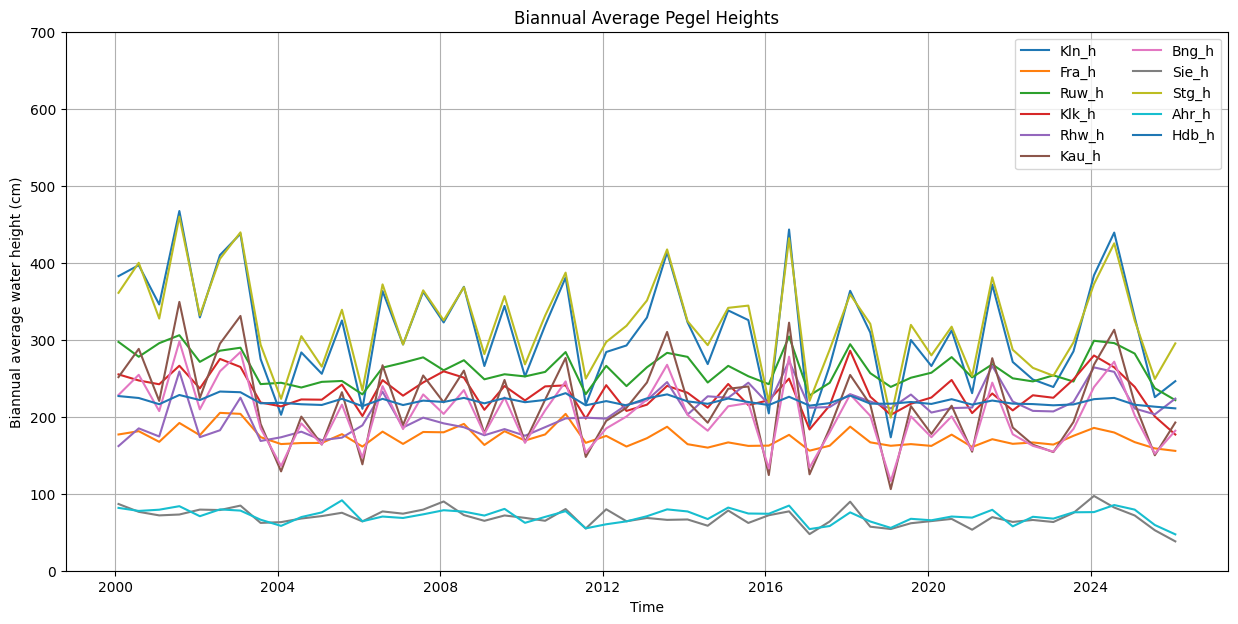

In [30]:
# Select only _h columns
h_cols = [col for col in df_all.columns if col.endswith("_h")]

# Resample to monthly mean (assuming df_all.index is a DateTimeIndex)
df_monthly = df_all[h_cols].resample("6M").mean()

plt.figure(figsize=(15, 7))

# Plot each monthly average
for col in h_cols:
    plt.plot(df_monthly.index, df_monthly[col], label=col)

plt.ylim(0, 700)
plt.xlabel("Time")
plt.ylabel("Biannual average water height (cm)")
plt.title("Biannual Average Pegel Heights")
plt.legend(loc="upper right", ncol=2)
plt.grid(True)
plt.show()


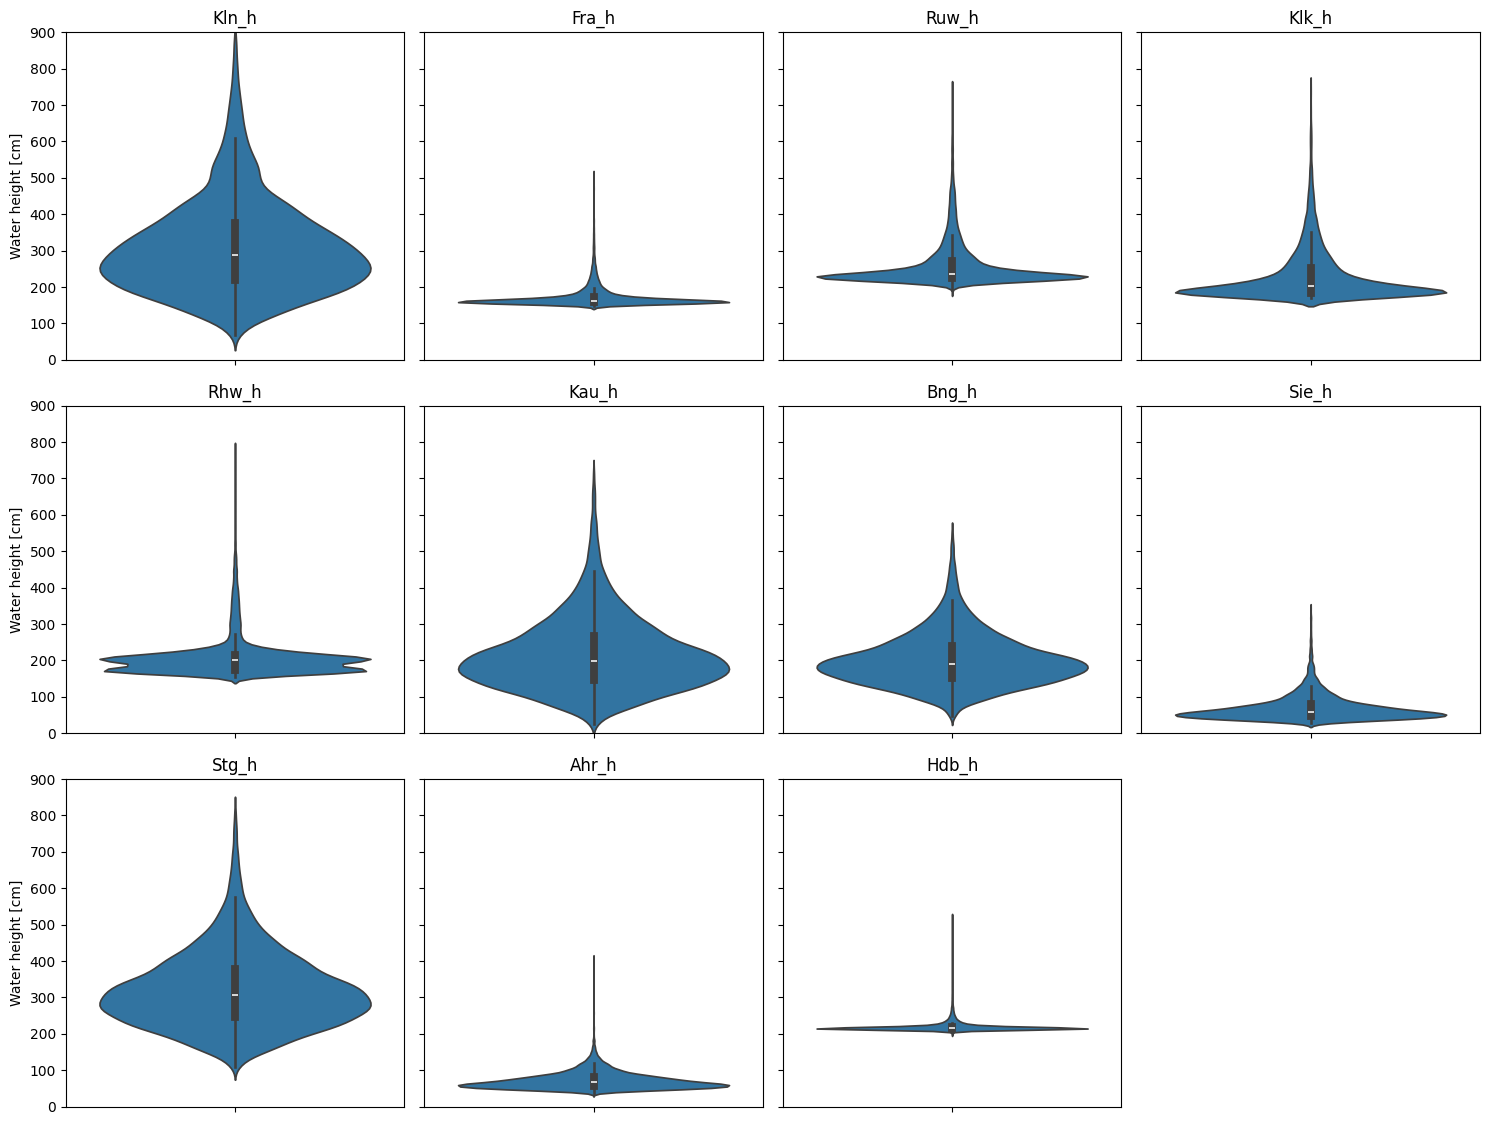

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select only columns that end with '_h'
h_cols = [col for col in df_all.columns if col.endswith("_h")]

# How many plots we need
n = len(h_cols)

# Grid size (NxN)
grid_size = int(np.ceil(np.sqrt(n)))

# Create subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15), sharey=True)
axes = axes.flatten()

# Plot each violin
for i, col in enumerate(h_cols):
    sns.violinplot(y=df_all[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")  # optional: hide x-labels
    axes[i].set_ylabel("Water height [cm]")
    axes[i].set_ylim(0, 900)  # fix y-axis

# Hide unused axes (if grid is larger than number of plots)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


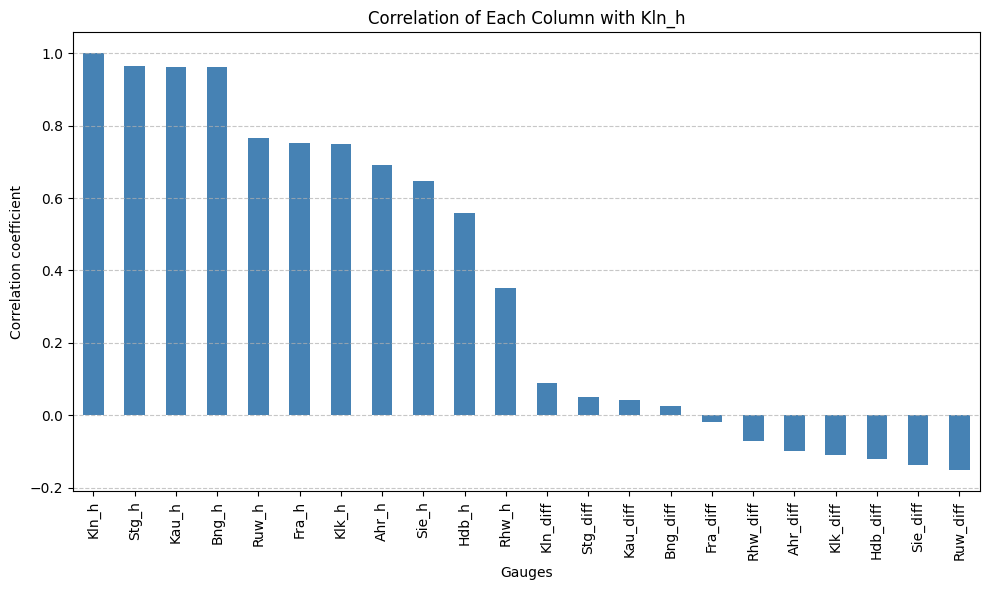

In [34]:
# Compute correlations of all columns with Kln_h
corr_to_kln = df_all.corr()["Kln_h"].sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
corr_to_kln.plot(kind="bar", color="steelblue")
plt.title("Correlation of Each Column with Kln_h")
plt.ylabel("Correlation coefficient")
plt.xlabel("Gauges")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

We seem to have the highest correlation with the middle rhine gauges at St. Goar, Kaub and Bingen.